In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle
from sklearn import metrics

In [2]:
import zipfile
z = zipfile.ZipFile('mnist.pkl.zip', 'r')
k = z.extract('mnist.pkl') # Извлечь файл из архива
with open(k, 'rb') as f:
    train_set, _, test_set = pickle.load(f, encoding="bytes")

In [3]:
train_set

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

In [4]:
def get_data(numbers):
    numbers = numbers
    n_classes = len(numbers)
    with open('mnist.pkl', 'rb') as f:
        train_set, _, test_set = pickle.load(f, encoding="bytes")
    x_train = train_set[0]
    x_test = test_set[0]
    x_train[x_train>=0.5] = 1
    x_train[x_train<0.5] = 0
    x_test[x_test>=0.5] = 1
    x_test[x_test<0.5] = 0
    y_train = train_set[1]
    y_test = test_set[1]
    idx_train = [[np.where(y_train==i)] for i in numbers]
    idx_test = [[np.where(y_test==i)] for i in numbers]
    idx_x_train = [x_train[idx_train[i][0]] for i in range(len(idx_train))]
    idx_x_test = [x_test[idx_test[i][0]] for i in range(len(idx_test))]
    idx_y_test = [y_test[idx_test[i][0]] for i in range(len(idx_test))]
    x_train_new = shuffle(np.concatenate(idx_x_train), random_state=42)
    x_test_new = shuffle(np.concatenate(idx_x_test), random_state=42)
    y_test_new = shuffle(np.concatenate(idx_y_test), random_state=42)
    return x_train_new, x_test_new, y_test_new, numbers, n_classes
x_train, x_test, y_test, numbers, n_classes = get_data([3, 7])

In [5]:
def plot_image(data, n_classes):
    for i in range(n_classes):
        img = np.array(data)[i]
        img_reshape = img.reshape((28,28))
        plt.imshow(img_reshape, cmap='gray')
        plt.show()

In [6]:
def init_parameters(data, n_classes):
    N = data.shape[0]
    K = n_classes
    D = data.shape[1]
    
    init_p_k_x = np.zeros((K, ))
    
    matrix = np.random.rand(N, K)
    matrix /= matrix.sum(axis=1)[:, None]
    for i in range(K):
        init_p_k_x[i] = sum(matrix[:, i])/matrix.shape[0]
    p_k_x_res = np.repeat(init_p_k_x, 28*28).reshape(K, D)
    
    init_p_k = np.random.uniform(0, 1, K)
    init_p_k /= np.sum(init_p_k)
#     print('init', init_p_k)
#     print(init_p_k.sum(axis=0))
    return p_k_x_res, init_p_k

In [7]:
def bernoulliMStep(data, p_k_x):
    '''Re-estimate the parameters using the current p_k_x
    data = N X D matrix
    p_k_x = N X K matrix
    return revised p_k (K vector) and p_i_j (K X D matrix)
    '''
    N = data.shape[0]
    D = data.shape[1]
    K = p_k_x.shape[1]
    #print('p_k_x', p_k_x)
    Nk = np.sum(p_k_x, axis=0)
    #print('nk',Nk)
    p_i_j_new = np.empty((K,D))
    
    for k in range(K):
            p_i_j_new[k] = np.sum(p_k_x[:,k][:, None]*data, axis=0)/Nk[k] #sum is over N data points            
#     print('nk/n', Nk/N)
#     print((Nk/N).sum())
    return Nk/N, p_i_j_new # Nk/N = new p_k

In [8]:
def BernoulliEStep(data, p_k, p_i_j):
    '''To compute expectation of the loglikelihood of Mixture of Beroullie distributions
    Since computing E(LL) requires computing responsibilities, this function does a double-duty
    to return responsibilities too
    '''
    N = data.shape[0]
    K = p_i_j.shape[0]
    
    #resp = respBernoulli(data, p_k, p_i_j) 
    p_k_x = np.empty((N, K))
    for i in range(N):
        for k in range(K):
            p_k_x[i,k] = np.prod((p_i_j[k]**data[i])*((1-p_i_j[k])**(1-data[i])))
    p_k_x *= p_k
    #print(p_k_x)
    #print(p_k_x.sum(axis=1))
    p_k_x /= p_k_x.sum(axis=1)[:, None]
    
    
    return p_k_x

In [9]:
def mixOfBernoulliEM(data, n_classes, maxiters=100):
    '''EM algo fo Mixture of Bernoulli Distributions'''
    N = data.shape[0]
    D = data.shape[1]
    K = n_classes
    
    #initalize
    init_p_k_x, init_p_k = init_parameters(data, K)
#     p_k = init_p_k[:]
#     p_i_j = init_p_i_j[:]
    p_k_x = BernoulliEStep(data, init_p_k, init_p_k_x)
    
    for i in range(maxiters):      
        #E Step: calculate resps
        #Skip, rolled into log likelihood calc
        #For 0th step, done as part of initialization
            
        #M Step
        p_k, p_i_j = bernoulliMStep(data, p_k_x)

        p_k_x = BernoulliEStep(data, p_k, p_i_j)
#     print(p_k)
#     print(p_i_j.shape)
#     print(p_i_j)
    return p_k, p_i_j

In [10]:
# def experiments(x, K, iters=10):
#     '''
#     Picks N random points of the selected 'digits' from MNIST data set and
#     fits a model using Mixture of Bernoulli distributions.
#     And returns the weights and means.
#     '''
#     D = x.shape[1]

#     init_p_k = np.random.uniform(0, 1, K)
#     init_p_k /= np.sum(init_p_k)

#     init_p_k_x = p_k_x_0(x, K)
#     #initMeans = np.full((K, D), 1.0/K)
    
#     return mixOfBernoulliEM(x, init_p_k, init_p_k_x, maxiters=iters)

In [11]:
# init_p_k_x, init_p_k = init_parameters(x_train, n_classes)

In [12]:
res_p_k, res_p_i_j = mixOfBernoulliEM(x_train, n_classes, maxiters=10)

In [13]:
#res_p_k, res_p_i_j = experiments(x_train, n_classes)

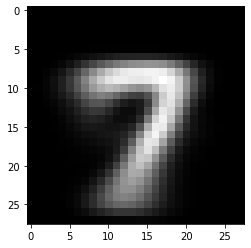

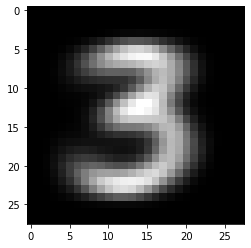

In [14]:
plot_image(res_p_i_j, n_classes)

In [15]:
def predict(data, labels, p_k, p_i_j, numbers):
    pred = BernoulliEStep(data, p_k, p_i_j).argmax(axis=1)
#     p_k_x = BernoulliEStep(data, p_k, p_i_j)
#     p_k, p_i_j_new = bernoulliMStep(data, p_k_x)
    print(pred[:20])
    for j in range(len(numbers)):
        print(j)
        print(numbers[j])
        for i in range(len(pred)):
            if pred[i] == j:
                #print(pred[i], i)
                pred[i] = numbers[j]
    print('metrics:', metrics.classification_report(labels, pred))
    return pred

In [16]:
with np.errstate(invalid='ignore'):
    predictions = predict(x_test, y_test, res_p_k, res_p_i_j, numbers)

[0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1]
0
3
1
7
metrics:               precision    recall  f1-score   support

           3       0.03      0.04      0.04      1010
           7       0.03      0.03      0.03      1028

    accuracy                           0.03      2038
   macro avg       0.03      0.03      0.03      2038
weighted avg       0.03      0.03      0.03      2038



In [17]:
from sklearn import metrics

In [18]:
y_test[:50]

array([7, 7, 7, 7, 3, 3, 3, 3, 7, 7, 3, 7, 3, 3, 3, 7, 7, 3, 7, 3, 3, 3,
       3, 7, 7, 7, 3, 7, 3, 7, 7, 7, 3, 3, 7, 3, 3, 3, 3, 3, 7, 7, 3, 3,
       3, 3, 3, 3, 7, 3], dtype=int64)

In [19]:
predictions[:50]

array([3, 3, 3, 3, 7, 7, 7, 7, 3, 3, 3, 3, 7, 7, 7, 3, 3, 7, 3, 7, 7, 7,
       7, 3, 3, 3, 7, 3, 7, 3, 3, 3, 7, 7, 3, 7, 7, 7, 7, 7, 3, 3, 7, 7,
       7, 7, 7, 7, 3, 7], dtype=int64)

In [20]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           3       0.03      0.04      0.04      1010
           7       0.03      0.03      0.03      1028

    accuracy                           0.03      2038
   macro avg       0.03      0.03      0.03      2038
weighted avg       0.03      0.03      0.03      2038



In [21]:
res_p_i_j[0]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0